In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import imageio
imageio.plugins.ffmpeg.download()

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    # get values of image size
    height = img.shape[0]
    width = img.shape[1]
    
    # generate blank lists
    x1_left = []
    x2_left = []
    y1_left = []
    y2_left = []
    x1_right = []
    x2_right = []
    y1_right = []
    y2_right = []
    
    x1_l_prev = 0
    x2_l_prev = 0
    y1_l_prev = 0
    y2_l_prev = 0
    x1_r_prev = 0
    x2_r_prev = 0
    y1_r_prev = 0
    y2_r_prev = 0
    
    # make lists each point stored
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / (x2-x1)
            # located on the left side
            if(slope < 0):
                if(x1 < width*0.5 or x2 < width*0.5):
                    x1_left.append(x1)
                    x2_left.append(x2)
                    y1_left.append(y1)
                    y2_left.append(y2)
                    x1_l_prev = x1
                    x2_l_prev = x2
                    y1_l_prev = y1
                    y2_l_prev = y2
                else:
                    x1_left.append(x1_l_prev)
                    x2_left.append(x2_l_prev)
                    y1_left.append(y1_l_prev)
                    y2_left.append(y2_l_prev)
            # located on the right side
            else:
                if(x1 > width*0.5 or x2 > width*0.5):
                    x1_right.append(x1)
                    x2_right.append(x2)
                    y1_right.append(y1)
                    y2_right.append(y2)
                    x1_r_prev = x1
                    x2_r_prev = x2
                    y1_r_prev = y1
                    y2_r_prev = y2
                else:
                    x1_right.append(x1_r_prev)
                    x2_right.append(x2_r_prev)
                    y1_right.append(y1_r_prev)
                    y2_right.append(y2_r_prev)
                    
    # calculate averages of each point
    x1_left_mean = np.mean(x1_left)
    x2_left_mean = np.mean(x2_left)
    y1_left_mean = np.mean(y1_left)
    y2_left_mean = np.mean(y2_left)
    x1_right_mean = np.mean(x1_right)
    x2_right_mean = np.mean(x2_right)
    y1_right_mean = np.mean(y1_right)
    y2_right_mean = np.mean(y2_right)
    
    # calculate slopes
    slope_left = (y2_left_mean - y1_left_mean) / (x2_left_mean - x1_left_mean)
    slope_right = (y2_right_mean - y1_right_mean) / (x2_right_mean - x1_right_mean) 
    
    # calculate intercepts of left and right side
    bias_left = y2_left_mean - slope_left * x2_left_mean
    bias_right = y2_right_mean - slope_right * x2_right_mean
    
    # apply one of the vertices mask points
    y_limit = int(height*0.6)
    
    # re-apply each point of slopes
    y1_left_ = y_limit
    y2_left_ = height
    x1_left_ = int((y1_left_ - bias_left) / slope_left)
    x2_left_ = int((y2_left_ - bias_left) / slope_left)
    y1_right_ = y_limit
    y2_right_ = height
    x1_right_ = int((y1_right_ - bias_right) / slope_right)
    x2_right_ = int((y2_right_ - bias_right) / slope_right)
    
    # draw each line
    cv2.line(img, (x1_left_, y1_left_), (x2_left_, y2_left_), color, thickness)
    cv2.line(img, (x1_right_, y1_right_), (x2_right_, y2_right_), color, thickness)

Source file: solidWhiteRight.jpg


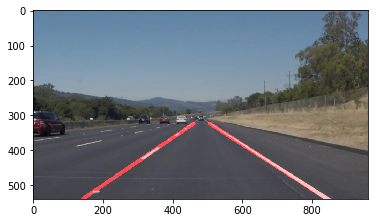

In [5]:
import os


def process(image, filename):
    # Parameters
    kernel_size = 3
    low_threshold = 50
    high_threshold = 150
    img_h = image.shape[0]
    img_w = image.shape[1]
    vertices = np.array([[(img_w*0.1, img_h),
                          (img_w*0.475, img_h*0.6), 
                          (img_w*0.525, img_h*0.6), 
                          (img_w*0.9, img_h)]], dtype=np.int32)    
    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_len = 30
    max_line_gap = 30
    
    gray = grayscale(image) # change to grayscle
    plt.imshow(gray, cmap='gray')
    plt.savefig("assets/"+filename[:-4]+"-gray.jpg")    
    
    blur_gray = gaussian_blur(gray, kernel_size) # apply gaussian blur
    plt.imshow(blur_gray)
    plt.savefig("assets/"+filename[:-4]+"-blurgray.jpg")    
    
    edges = canny(blur_gray, low_threshold, high_threshold) # Canny edge detection
    plt.imshow(edges)
    plt.savefig("assets/"+filename[:-4]+"-edges.jpg")    
        
    masked_edges = region_of_interest(edges, vertices) # mask the region of interest
    plt.imshow(masked_edges)
    plt.savefig("assets/"+filename[:-4]+"-region.jpg")    
        
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # Hough transfrom
    line_edges = weighted_img(lines, image) # draw lines to the original image
    plt.imshow(line_edges)
    plt.savefig("assets/"+filename[:-4]+"-result.jpg")    
    
    return line_edges


def load_and_run(dir, file):
    print("Source file: " + file)
    image = mpimg.imread(dir + file)
    output = process(image, file)

load_and_run("test_images/", "solidWhiteRight.jpg")

In [6]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Source file: shortcoming2.jpg


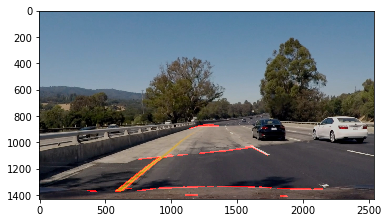

In [7]:
def process(image, filename):
    # Parameters
    kernel_size = 3
    low_threshold = 50
    high_threshold = 150
    img_h = image.shape[0]
    img_w = image.shape[1]
    vertices = np.array([[(img_w*0.1, img_h),
                          (img_w*0.475, img_h*0.6), 
                          (img_w*0.525, img_h*0.6), 
                          (img_w*0.9, img_h)]], dtype=np.int32)    
    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_len = 30
    max_line_gap = 30
    
    gray = grayscale(image) # change to grayscle
    plt.imshow(gray, cmap='gray')
    plt.savefig("assets/"+filename[:-4]+"-gray.jpg")    
    
    blur_gray = gaussian_blur(gray, kernel_size) # apply gaussian blur
    plt.imshow(blur_gray)
    plt.savefig("assets/"+filename[:-4]+"-blurgray.jpg")    
    
    edges = canny(blur_gray, low_threshold, high_threshold) # Canny edge detection
    plt.imshow(edges)
    plt.savefig("assets/"+filename[:-4]+"-edges.jpg")    
        
    masked_edges = region_of_interest(edges, vertices) # mask the region of interest
    plt.imshow(masked_edges)
    plt.savefig("assets/"+filename[:-4]+"-region.jpg")    
        
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) # Hough transfrom
    line_edges = weighted_img(lines, image) # draw lines to the original image
    plt.imshow(line_edges)
    plt.savefig("assets/"+filename[:-4]+"-result.jpg")    
    
    return line_edges


def load_and_run(dir, file):
    print("Source file: " + file)
    image = mpimg.imread(dir + file)
    output = process(image, file)

#load_and_run("test_images/", "solidWhiteRight.jpg")
load_and_run("assets/", "shortcoming2.jpg")